# GAHN ALIOUNE BADARA BA 

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import os
import re
import community

pip install python-louvain #Installer cette bibliotheque si ce n'est deja fait 

In [2]:
useruser=nx.DiGraph() # Graph user user

In [191]:
docdoc = nx.Graph() # Graph Documents-documents

In [293]:
pathfile= '/fake-news-prediction-toulouse/data_competition/UserUser.txt' #useruser.text 
pathfile1 = '/fake-news-prediction-toulouse/data_competition/newsUser.txt' #newsuser.text
#Nous avons modifié le fichier "labels_training.txt" pour faciliter son importation avec notre code. Nous avons juste enlevé la première ligne ('doc,class'). Nous le joignons dans notre dossier (vous pouvez le modifier dans votre fichier si vous préferez).
pathfile3= '/fake-news-prediction-toulouse/data_competition/labels_training.txt' #labels_training.text
pathtest = '/fake-news-prediction-toulouse/data_competition/news/test/' #path to test directory
pathtrain = '/fake-news-prediction-toulouse/data_competition/news/training/' #path to train directory


In [292]:
#Cette fonction nous permets d'importer les documents train ou test sous forme de dataframe
def indexation1(directory=pathtrain):
    listDoc = os.listdir(directory)
    df = pd.DataFrame(columns=['doc','body','title','lastphrases'])
    for fichier in listDoc:
        if re.match('[0-9]+',fichier[0:-4]) and fichier[-4:] == '.txt':
            # option encoding pour éviter les problèmes d'encodage 
            f = open(directory+fichier,'r',encoding = 'utf-8')
            numFichier = int(fichier[0:-4])
            f1 = [l.strip() for l in f]
            title = f1[0] 
            lastphrases = f1[len(f1)-1]
            body = ''
            for i in range(1,len(f1)):
                body = body+' '+ f1[i] 
            row = pd.Series([numFichier,body,title, lastphrases], index=df.columns)
            df = df.append(row, ignore_index=True, sort=False)
    
    df = df.sort_values(by=['doc'])
    df = df.reset_index(drop=True)
    
    # transformer le type de la colonne 'doc' afin qu'elle soit en int 64 pour pouvoir par la suite effectuer 
    # des jointures avec d'autres dataframes.
    df.doc = df.doc.astype(np.int64)
        
    return(df)

In [289]:
dftrain = indexation1() # Chargement dftrain
dftest = indexation1(pathtest) # Chargement dftest
newsuser = readtxt(pathfile1,3) # Chargement news user file

In [6]:
#Cette fonction prend en entrée un fichier de données numériques text et renvoie une liste de listes contenant chacune 
# une colonne du fichier
def readtxt(pathfile ,k ):
    data = [ int(z) for z in open(pathfile, 'r').read().split() ]
    liste = []
    j = 0
    while j <= (k-1):
        liste.append([data[i] for i in range(j, len(data),k)])
        j = j+1
    return(liste)

In [271]:
nodes=[ int(z) for z in open(pathfile, 'r').read().split() ]
nodes =list(set(nodes))  # Nodes graph user

In [8]:
edges = readtxt(pathfile,2) #edges graph user
edges= [(edges[0][i], edges[1][i])for i in range (len(edges[0]))] 

In [278]:
label = readtxt(pathfile3 , 2) 
label = pd.DataFrame({'doc':label[0],'class':label[1]})
label = label.set_index(label['doc'].values)

In [9]:
useruser.add_nodes_from(nodes) # Adding useruser graph nodes

In [10]:
useruser.add_edges_from(edges) # Adding user user graph edges

In [273]:
# Fonction nous permets d'affecter un score de crédibilité à un news en fonction de la moyenne des notes de crédibilités 
# des utilisateurs qui partagent ce news
def credibilitynews(creduser, newsuser):
    cred = {}
    for i, news in enumerate (newsuser[0]):
        if news not in (cred.keys()):
            cred[news] = [newsuser[1][i]]
            for j, news1 in enumerate (newsuser[0]):
                if news == news1:
                    cred[news].append(newsuser[1][j])
    for k in cred.keys():
        liste= []
        for i in cred[k][1:]:
            if i in creduser.keys():
                 liste.append(creduser[i])
        cred[k]= np.mean(liste)
    return(cred)  

# Calcul de Centralités sur le Graphe

Notre Première intuition est de trouver les utilisateurs influenceurs. Ces utilisateurs en général ne tweetent que de bonnes nouvelles.
Nous définissons un influenceur comme un utilisateur qui est suivi par beaucoup d'utilisateurs

Calculons les In Degrees Centrality:

In [225]:
incentralities = nx.in_degree_centrality(useruser)

Dans cette première approche, Nous considèrons que plus un utilisateur est suivi , plus il est crédible. 
La crédibilté de l'utilisateur est associé ici à la valeur de la in-centrality dans le graphe. 
Calculons donc la crédibilité des documents et représentons les résultats

In [274]:
credocs = credibilitynews(incentralities, newsuser)

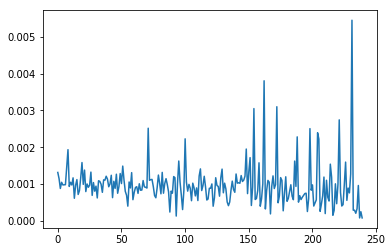

In [275]:
credocs = [credocs[k] for k in credocs.keys()]
plt.plot(np.arange(0, len(credocs)), credocs)

Nous voyons ici que notre feature nous dit que les documents labelisés fake news on tendance à etre plus credible. 
Nous allons donc essayer de redefinir la crédibilité d'un utilisateur par rapport aux notes qu'il a deja donné pour voir.

In [276]:
# Cette fonction permets de Calculer la crédibilité d'un utilisateur par rapport aux notes qu'il a deja donné. 
# credibility = nbre de bonnes news - nombre de fakenews. 
def credibilityuser (listuser, labels, newsuser):
    cred = {}
    for i in listuser:
        cred[i]= [0,0] 
    for j,news in enumerate (newsuser[0]):
        if news in (labels['doc'].values):
            if (labels['class'][news]==0):
                cred[newsuser[1][j]][0] = cred[newsuser[1][j]][0] + newsuser[2][j]
            else : 
                cred[newsuser[1][j]][1] = cred[newsuser[1][j]][1] + newsuser[2][j]
    for k in cred.keys():
        cred[k]= cred[k][0] - cred[k][1]
    return (cred)

In [ ]:
creduser = credibilityuser(nodes, label, newsuser) # Calcul de la credibility_user basée sur les notes

In [333]:
crednews = credibilitynews(creduser, newsuser) #credibility des news
crednews = pd.DataFrame.from_dict(crednews, orient = 'index')
crednews.insert(0, 'doc', crednews.index)
crednews.columns = ['doc', 'credibility']


In [399]:
# On assigne à un document 0 si sa crédibilité est negative et 1 sinon
for j in crednews.index:
    if crednews['credibility'][j] > 0 : 
        crednews['credibility'][j] = 0
    else:
        crednews['credibility'][j] = 1

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Testons notre feature

In [400]:
crednewstrain = pd.merge(dftrain,crednews, on= 'doc')
crednewstest = pd.merge(dftest,crednews, on= 'doc')

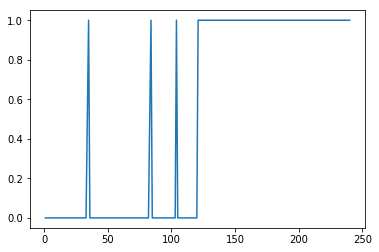

In [401]:
plt.plot(crednewstrain['doc'].values,crednewstrain['credibility'].values)

Cette sortie nous montre que notre feature nous prédit à 100% la crédibility du news. 
La credibility est positive pour les documents vrai (id < 120) et est negative pour les fake news.
Maintenant , Essayons de trouver un clustering de documents en faisant un graphe documents documents. 
Deux documents sont liés s'ils sont partagés par le même utilisateur

In [402]:
#Construction du feature
dfxtrain = crednewstrain[['doc', 'credibility']]
dfxtest = crednewstest[['doc', 'credibility']]

# Graphe de Documents

Construison maintenant un graphe documents documents. Deux documents sont liés s'ils sont partagés par le même utilisateur

In [13]:
# Cette fonction nous permets de trouver les documents qui on été partagés par le meme utilisateur 
def buildedges(newsuser):
    edges = []
    for i in range(len(newsuser[0])):
        for j in range(len(newsuser[0])):
            if j!= i : 
                if newsuser[1][j] == newsuser[1][i]:
                    edges.append((newsuser[0][j],newsuser[0][i]))
    return(edges)
                    

In [14]:
edges1 = buildedges(newsuser) # document document edges

In [290]:
#On calcule ici les poids des relations. 
weights = {}
for i,k in enumerate(edges1):
    if k not in weights.keys():
        weights[k] = edges1.count(edges1[i])

In [294]:
edges1 = list(set(edges1))
nodes1 =list(set(newsuser[0]))

In [380]:
#On ajoute les nodes dans le graphe de documents
docdoc.add_nodes_from(nodes1)

In [381]:
# Ce bout de code nous permets d'inserer les edges dans un graphe et supprimer les noeuds qui ne sont liés à aucun autre document
for k in edges1:
    a = k[0]
    b = k[1]
    c = weights[k]
    w = [(a,b,c)]
    docdoc.add_weighted_edges_from(w)

<Figure size 432x288 with 0 Axes>

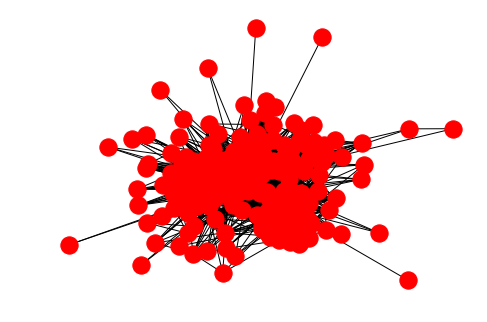

<Figure size 432x288 with 0 Axes>

In [416]:
copydocdoc = docdoc.copy() # Affichage du graphe
copydocdoc.remove_nodes_from(list(nx.isolates(copydocdoc)))
nx.draw(copydocdoc)
plt.figure() 

## Détection de Communautés 

In [383]:
# preform Louvain method for community detection
louvain_clusters = community.best_partition(docdoc)

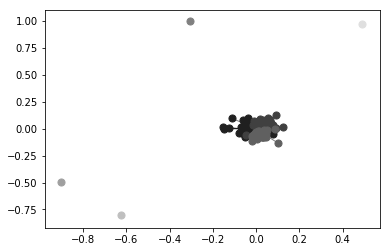

In [417]:
size = float(len(set(louvain_clusters.values())))
pos = nx.spring_layout(docdoc)
count = 0.
for com in set(louvain_clusters.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in louvain_clusters.keys()
                                if louvain_clusters[nodes] == com]
    nx.draw_networkx_nodes(copydocdoc, pos, list_nodes, node_size = 50,
                                node_color = str(count / size))


nx.draw_networkx_edges(docdoc, pos, alpha=0.5)
plt.show()



La sortie de ce cluster nous montre que nous avons des groupes homogènes. Certains clusters sont constitués que de fake news tandis que d'autres sont constitués que de fake news nous allons donc garder ce feature

In [406]:
# Construction du Feature
louvain = pd.DataFrame.from_dict(louvain_clusters, orient='index')
louvain.insert(0, 'doc', louvain.index)
louvain.columns = ['doc', 'louvaincluster']
dfxtrain = pd.merge(louvain,dfxtrain, on = 'doc')
dfxtest = pd.merge (louvain, dfxtest, on = 'doc')

In [387]:
# get Kernighan bisection communities
kernighan_bisection = nx.community.kernighan_lin_bisection(docdoc)

Ce clustering aussi nous dissocie bien les fake news des vrais, nous allons donc aussi garder ce feature

In [388]:
zeros = pd.DataFrame ( { 'doc' :list (kernighan_bisection[0]),'class': list(np.zeros(len(list (kernighan_bisection[0]))))})
ones = pd.DataFrame ( { 'doc' :list (kernighan_bisection[1]),'class': list(np.ones(len(list (kernighan_bisection[1]))))})

In [389]:
kernighan = pd.concat([ones,zeros])
kernighan.columns = ['doc', 'kernighancluster']

In [408]:
dfxtrain = pd.merge( dfxtrain, kernighan, on = 'doc')
dfxtest = pd.merge (dfxtest, kernighan, on = 'doc')

##### On sauvegarde notre dataframe de features network en csv et on va les combiner avec nos features text pour faire nos prédictions.

In [411]:
dfxtrain.to_csv('/xtrainnetwork.txt', index=False, header=1)
dfxtest.to_csv('/xtestnetwork.txt', index=False, header=1)